In [1]:
import tensorflow as tf

In [2]:
import torch

In [3]:
#check the availability of gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [4]:
!pip install transformers

In [5]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=fce29fb65d5e37a69f37ee953a29e39c658498c2725c181b2c5910529d165531
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [6]:
import wget
import os

In [7]:
# dataset url
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [8]:
# unzip the data
if not os.path.exists('./cola_public/'):
  !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [9]:
import pandas as pd

#Load the dataset into a pandas dataframe
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv",delimiter='\t',header = None, names = ['sentence_source','label','label_notes','sentence'])

#Report the no. of Sentences
print("No. of training sentences : {:,}\n".format(df.shape[0]))

#display 10 random rows from the data
df.sample(10)

No. of training sentences : 8,551



,sentence_source,label,label_notes,sentence
6674,m_02,1,NaN,That piano was bought for his secret fiancée b...
3069,l-93,1,NaN,Ellen talked with Helen.
4524,ks08,1,NaN,"They can do it, can't they?"
2742,l-93,0,*,Carmen bought a dress to Mary.
2226,l-93,1,NaN,This knife cut the bread.
5891,c_13,1,NaN,Andrew is in Tucson's finest apartment.
515,bc01,0,*,The electrode was left by ions.
730,bc01,1,NaN,This book cost $10.
4000,ks08,1,NaN,He is proud of his son's passing the bar exam.
4759,ks08,1,NaN,"Edward's help, you can rely on."


In [10]:
df.loc[df.label == 0].sample(5)[['sentence','label']]

,sentence,label
2550,Cheryl stood the books from Edna to Sarah.,0
7294,My niece could write me you letters.,0
3882,They eager to leave the meeting.,0
3276,There soared oil in price.,0
8168,We believed to be the headmaster,0


In [11]:
# get the lists of sentence and their labels
sentences = df.sentence.values
labels = df.label.values

In [12]:
sentences[0:5]

array(["Our friends won't buy this analysis, let alone the next one we propose.",
       "One more pseudo generalization and I'm giving up.",
       "One more pseudo generalization or I'm giving up.",
       'The more we study verbs, the crazier they get.',
       'Day by day the facts are getting murkier.'], dtype=object)

In [13]:
labels

array([1, 1, 1, ..., 1, 1, 1])

In [14]:
from transformers import BertTokenizer

#Load the bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
#print original sentence
print('Original : ',sentences[0])

#print the sentence splits into tokens
print('Tokenized : ',tokenizer.tokenize(sentences[0]))

#print the sentence as tokens mapped to ids
print('Tokens ids : ',tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original :  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized :  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Tokens ids :  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [16]:
# we will find maximum length of sentence

max_len = 0

for sent in sentences:
  #tokenize the sentence and add [CLS] and [SEP] tokens
  input_ids = tokenizer.encode(sent,add_special_tokens=True)

  #update the maximum sentence length
  max_len = max(max_len,len(input_ids))

print('Max sentence length : ',max_len)

Max sentence length :  47


In [17]:
#tokenzie all sentences and map them to their id
input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
      sent, # input sentence
      add_special_tokens = True, # add [CLS] and [SEP] token
      max_length = 64, #pad and truncate to max length
      truncation = True,
      padding = 'max_length' ,
      return_attention_mask = True, #attention mask
      return_tensors = 'pt' #convert pytorch tensor
  )

  #add encoded_dict to input_ids
  input_ids.append(encoded_dict['input_ids'])

  #add attention mask
  attention_masks.append(encoded_dict['attention_mask'])

#Convert the list into tensors
input_ids = torch.cat(input_ids,dim = 0)
attention_masks = torch.cat(attention_masks,dim = 0)
labels = torch.tensor(labels)

#compare original vs token id of sentence[0]
print('Orignal : ',sentences[0])
print('Token Ids: ',input_ids[0])

Orignal :  Our friends won't buy this analysis, let alone the next one we propose.
Token Ids:  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


**Splitting data**

In [18]:
from torch.utils.data import TensorDataset,random_split

#generating dataset
dataset = TensorDataset(input_ids,attention_masks,labels)

#dividing dataset into 0.9 to train and 0.1 test
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('{:5,} training samples'.format(train_size))
print('{:5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


**Data Loading**

In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

#dataloader for training data
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

#dataloader for validation data
validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

**Model Loading**

In [38]:
from transformers import BertForSequenceClassification, BertConfig

#loading model with linear classification model on top
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", #This model has 12 layers
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

#check if gpu is available else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Move model to device
model.to(device)

print("Model is running on : ",device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model is running on :  cuda


In [39]:
params = list(model.named_parameters())
print("The model has {:} different named parameters.\n".format(len(params)))

print("==== Embedding Layer ====\n")

for p in params[0:5]:
  print("{:<55} {:>12}".format(p[0],str(tuple(p[1].size()))))

print("\n==== First Transformer ====\n")

for p in params[5:21]:
  print("{:<55} {:>12}".format(p[0],str(tuple(p[1].size()))))

print("\n==== Output Layer ====\n")

for p in params[-4:]:
  print("{:<55} {:>12}".format(p[0],str(tuple(p[1].size()))))

The model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)

**Optimizer**

In [40]:
# from torch.optim import AdamW
from transformers import AdamW
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:
from transformers import get_linear_schedule_with_warmup

#no.of epochs
epochs = 4

#total steps of training
total_steps = len(train_dataloader) * epochs

#learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

**Training**

In [42]:
import numpy as np

#fn. to calculate accuracy
def flat_accuracy(preds,labels):
  pred_flat = np.argmax(preds,axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)

In [43]:
import time
import datetime

def format_time(elapsed):
  #round to nearest second
  elapsed_rounded = int(round((elapsed)))

  #format as hh:mm:ss
  return str(datetime.timedelta(seconds = elapsed_rounded))

In [44]:
import random
import numpy as np

seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed(seed_val)

#for storing during training
training_stats = []

total_t0 = time.time()

for epoch_i in range(0,epochs):
  print("----->Epoch {:}/{:}<------".format(epoch_i+1,epochs))

  t0 = time.time()

  total_train_loss = 0

  model.train()

  for step,batch in enumerate(train_dataloader):
      if step%40 == 0 and not step == 0 :
        elapsed = format_time(time.time() - t0)

        print(' Batch  {:>5,} of {:>5,}. Elapsed: {:}.'.format(step,len(train_dataloader),elapsed))

      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      model.zero_grad()

      output = model(b_input_ids,token_type_ids = None,
                          attention_mask = b_input_mask,labels = b_labels,return_dict = True)

      loss = output.loss
      logits = output.logits

      total_train_loss += loss.item()

      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

      optimizer.step()

      scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)

  training_time = format_time(time.time() - t0)

  print("Average Training Loss : {0:.2f}".format(avg_train_loss))
  print("Training epcoh took : {:}".format(training_time))

  print("--------")
  print("Validation ...")


  t0 = time.time()

  model.eval()

  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0


  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():

      output = model(b_input_ids,token_type_ids = None,
                            attention_mask = b_input_mask,
                            labels = b_labels,return_dict = True
                            )

    loss = output.loss
    logits = output.logits

    total_eval_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    total_eval_accuracy += flat_accuracy(logits,label_ids)


  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
  avg_val_loss = total_eval_loss / len(validation_dataloader)
  validation_time = format_time(time.time() - t0)

  print(" Validation loss : {0:.2f}".format(avg_val_loss))
  print("Validation epoch took : {:}".format(validation_time))

  training_stats.append(
      {
          'epoch':epoch_i+1,
          'Training Loss':avg_train_loss,
          'Valid Loss':avg_val_loss,
          'Training Time':training_time,
          'Validation Time':validation_time
      }
  )

print("Training Complete")
print("Training took {:}".format(format_time(time.time() - total_t0)))

----->Epoch 1/4<------
 Batch     40 of   241. Elapsed: 0:00:13.
 Batch     80 of   241. Elapsed: 0:00:25.
 Batch    120 of   241. Elapsed: 0:00:38.
 Batch    160 of   241. Elapsed: 0:00:51.
 Batch    200 of   241. Elapsed: 0:01:03.
 Batch    240 of   241. Elapsed: 0:01:16.
Average Training Loss : 0.49
Training epcoh took : 0:01:16
--------
Validation ...
  Accuracy: 0.82
 Validation loss : 0.42
Validation epoch took : 0:00:03
----->Epoch 2/4<------
 Batch     40 of   241. Elapsed: 0:00:12.
 Batch     80 of   241. Elapsed: 0:00:25.
 Batch    120 of   241. Elapsed: 0:00:37.
 Batch    160 of   241. Elapsed: 0:00:50.
 Batch    200 of   241. Elapsed: 0:01:02.
 Batch    240 of   241. Elapsed: 0:01:15.
Average Training Loss : 0.30
Training epcoh took : 0:01:15
--------
Validation ...
  Accuracy: 0.83
 Validation loss : 0.42
Validation epoch took : 0:00:03
----->Epoch 3/4<------
 Batch     40 of   241. Elapsed: 0:00:12.
 Batch     80 of   241. Elapsed: 0:00:25.
 Batch    120 of   241. Elapsed

In [45]:
import pandas as pd

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data = training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid Loss,Training Time,Validation Time
epoch,,,,
1,0.49,0.42,0:01:16,0:00:03
2,0.30,0.42,0:01:15,0:00:03
3,0.19,0.48,0:01:15,0:00:03
4,0.13,0.57,0:01:15,0:00:03


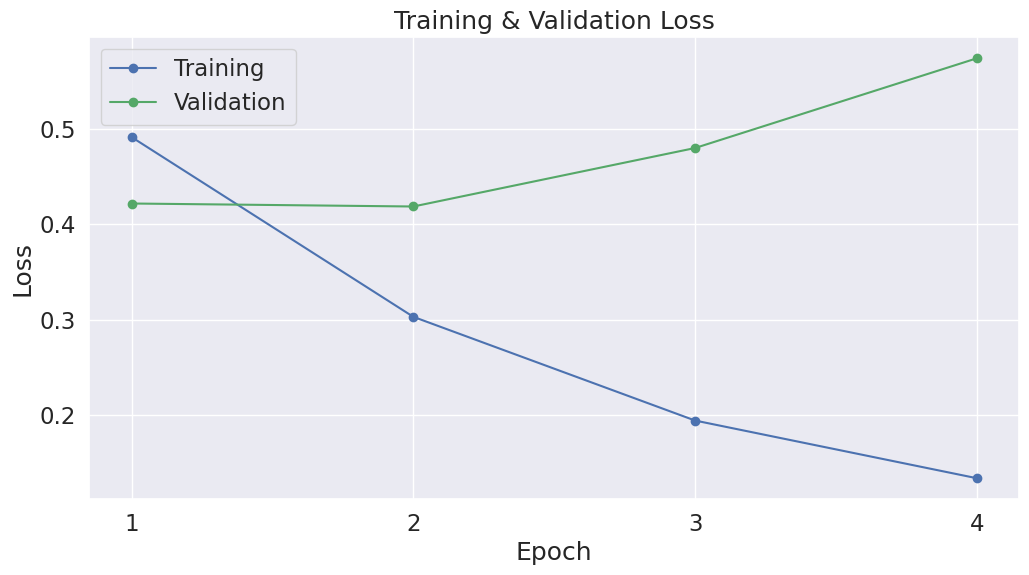

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style = 'darkgrid')

sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (12,6)

#plotting the training loss and validation loss
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [48]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv",delimiter = '\t',header = None,names = ['sentence_source','label','label_notes','sentence'])
print("Number of test sentences: {:,}\n".format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
      sent,
      add_special_tokens = True,
      max_length = 64,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt'
  )

  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids,dim = 0)
attention_masks = torch.cat(attention_masks,dim = 0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids,attention_masks,labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data,sampler = prediction_sampler,batch_size = batch_size)

Number of test sentences: 516



In [49]:
print("predicting label for {:,} test sentences".format(len(input_ids)))

model.eval()

predictions = []
true_labels = []

for batch in prediction_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad():
    outputs = model(b_input_ids,token_type_ids = None,
                    attention_mask = b_input_mask)

  logits = outputs.logits

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.detach().cpu().numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

predicting label for 516 test sentences


In [56]:
true_labels

[array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1]),
 array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
 array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 1]),
 array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1]),
 array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0]),
 array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1]),
 array([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 

In [50]:
outputs.logits

tensor([[-2.8514,  2.4033],
        [-2.9179,  2.5526],
        [-2.1425,  1.9580],
        [-2.8361,  2.5930]], device='cuda:0')

In [51]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-2.8514,  2.4033],
        [-2.9179,  2.5526],
        [-2.1425,  1.9580],
        [-2.8361,  2.5930]], device='cuda:0'), hidden_states=None, attentions=None)

In [52]:
outputs[0]

tensor([[-2.8514,  2.4033],
        [-2.9179,  2.5526],
        [-2.1425,  1.9580],
        [-2.8361,  2.5930]], device='cuda:0')

In [53]:
print("Positive samples : %d of %d (%.2f%%)" %(df.label.sum(),len(df.label),(df.label.sum()/len(df.label) * 100)))

Positive samples : 354 of 516 (68.60%)


In [54]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
print("calculate matthews correlation coefficient for each batch")
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i],axis = 1).flatten()
  matthews = matthews_corrcoef(true_labels[i],pred_labels_i)
  matthews_set.append(matthews)

calculate matthews correlation coefficient for each batch


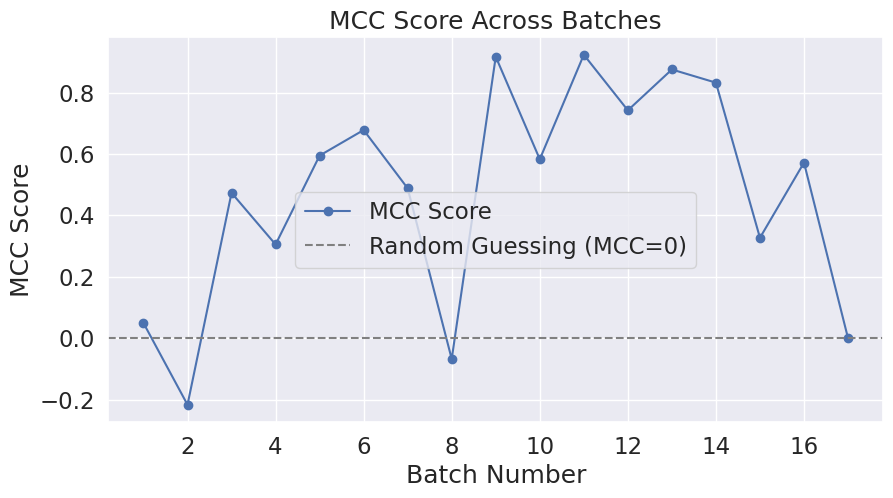

In [55]:
import matplotlib.pyplot as plt

# Example MCC scores for batches
batch_numbers = list(range(1, len(matthews_set) + 1))
mcc_scores = matthews_set

plt.figure(figsize=(10,5))
plt.plot(batch_numbers, mcc_scores, marker='o', linestyle='-', color='b', label="MCC Score")
plt.axhline(y=0, color='gray', linestyle='--', label="Random Guessing (MCC=0)")
plt.xlabel("Batch Number")
plt.ylabel("MCC Score")
plt.title("MCC Score Across Batches")
plt.legend()
plt.show()


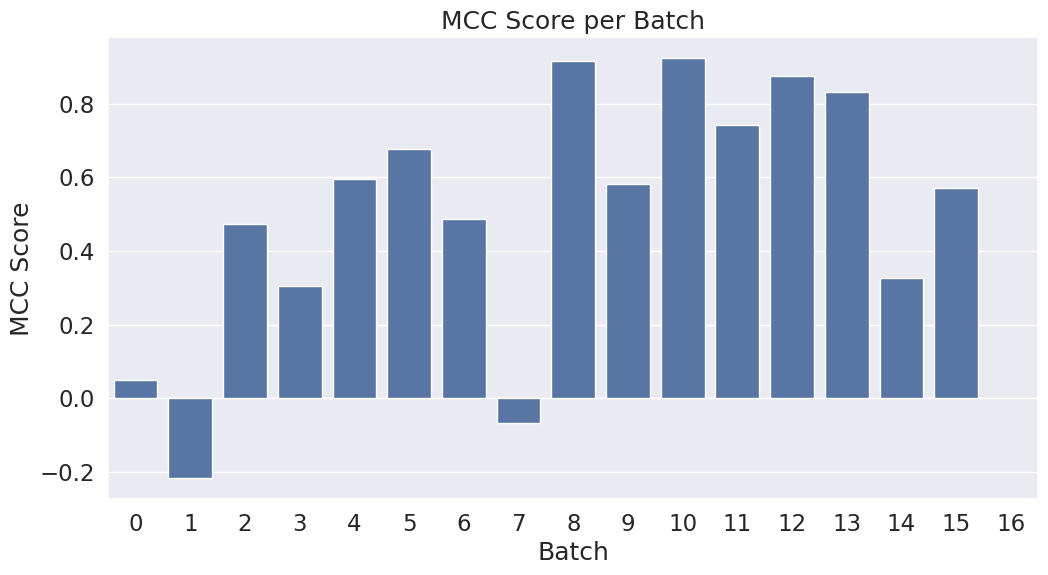

In [58]:
ax = sns.barplot(x = list(range(len(matthews_set))),y = matthews_set,errorbar = None)

plt.title("MCC Score per Batch")
plt.ylabel("MCC Score")
plt.xlabel("Batch")

plt.show()

In [59]:
flat_predictions = np.concatenate(predictions,axis = 0)

flat_predictions = np.argmax(flat_predictions,axis = 1).flatten()

flat_true_labels = np.concatenate(true_labels,axis = 0)

mcc_score = matthews_corrcoef(flat_true_labels,flat_predictions)

print("Total MCC Score : {0:.2f}".format(mcc_score))

Total MCC Score : 0.54


In [63]:
import os

output_dir = "./model_save/"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

training_args = {
    'epochs': epochs,
    'batch_size': batch_size,
    'learning_rate': 2e-5,
    # Add other training arguments as needed
}

torch.save(training_args, os.path.join(output_dir, "training_args.bin"))


Saving model to ./model_save/


In [64]:
!ls ./model_save/

config.json	   special_tokens_map.json  training_args.bin
model.safetensors  tokenizer_config.json    vocab.txt


In [65]:
!ls -l ./model_save/

total 427940
-rw-r--r-- 1 root root       727 Mar 14 06:41 config.json
-rw-r--r-- 1 root root 437958648 Mar 14 06:41 model.safetensors
-rw-r--r-- 1 root root       125 Mar 14 06:41 special_tokens_map.json
-rw-r--r-- 1 root root      1272 Mar 14 06:41 tokenizer_config.json
-rw-r--r-- 1 root root       952 Mar 14 06:41 training_args.bin
-rw-r--r-- 1 root root    231508 Mar 14 06:41 vocab.txt


In [67]:
!ls -l --block-size=k ./model_save/

total 427940K
-rw-r--r-- 1 root root      1K Mar 14 06:41 config.json
-rw-r--r-- 1 root root 427694K Mar 14 06:41 model.safetensors
-rw-r--r-- 1 root root      1K Mar 14 06:41 special_tokens_map.json
-rw-r--r-- 1 root root      2K Mar 14 06:41 tokenizer_config.json
-rw-r--r-- 1 root root      1K Mar 14 06:41 training_args.bin
-rw-r--r-- 1 root root    227K Mar 14 06:41 vocab.txt


In [70]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [71]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "/content/drive/MyDrive/Bert_Finetuning""

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
